influence model definition

In [8]:
topology = [("sales", "value"), ("dev costs", "value"), 
            ("feature set", "dev costs"), ("debt amount", "dev costs"), 
            ("feature set", "sales"), 
            ("feature set", "decision 1"), 
            ("decision 1", "debt amount"), ("decision 2", "debt amount"), ]

draw the model graph

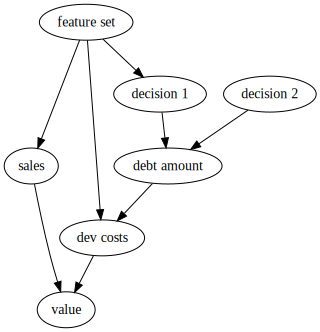

In [9]:
from graphviz import Digraph


dot = Digraph(comment='Influences')
dot.edges(topology)
dot

create a networkx model graph to use as a primary data structure for manipulations

In [10]:
import networkx as nx


model = nx.DiGraph()
model.add_edges_from(topology)

perform topological sort to sort nodes in the order of dependencies (and reversed)

In [11]:
ordered_nodes = nx.topological_sort(model)
reverse_ordered_nodes = nx.topological_sort(model, reverse=True)

print("topologically ordered nodes", "=", ordered_nodes)
print("topologically ordered nodes in reverse", "=", reverse_ordered_nodes)

topologically ordered nodes = ['feature set', 'decision 1', 'decision 2', 'debt amount', 'dev costs', 'sales', 'value']
topologically ordered nodes in reverse = ['value', 'sales', 'dev costs', 'debt amount', 'decision 2', 'decision 1', 'feature set']


compute variants

In [13]:
for node in ordered_nodes:
    print(node, "<-", model.in_edges(node))
    for edge in model.in_edges_iter(node):
        pass

feature set <- []
decision 1 <- [('feature set', 'decision 1')]
decision 2 <- []
debt amount <- [('decision 2', 'debt amount'), ('decision 1', 'debt amount')]
dev costs <- [('feature set', 'dev costs'), ('debt amount', 'dev costs')]
sales <- [('feature set', 'sales')]
value <- [('sales', 'value'), ('dev costs', 'value')]


define options for the nodes

In [69]:
import itertools

options = {
    'feature set': ('f1', 'f2', 'f3'),
    'decision 2': ('d2-o1', 'd2-o2')
}

id_gen = lambda node, inputs: options[node]

uncertain_gen = lambda node, inputs: '?'

def d1_gen(node, inputs):
    opts = {'f1': ('d1-o1',), 'f2': ('d1-o2',), 'f3': ('d1-o2',)}
    return opts[inputs[0]]

def debt_gen(node, inputs):
    d2, d1 = inputs
    if d1 == 'd1-o1':
        return (1.2,)
    elif d1 == 'd1-o2'and d2 == 'd2-o2':
        return (0.9,)
    else:
        return (1.0,)
    
def dev_gen(node, inputs):
    f, debt = inputs
    if f == 'f1':
        effort = 1200
    elif f == 'f2':
        effort = 1100
    else:
        effort = 800
    effort = effort * debt
    rate = 50
    return (effort * rate,)
    
def sales_gen(node, inputs):
    opts = {'f1': (100000.0,), 'f2': (80000.0,), 'f3': (50000.0,)}
    return opts[inputs[0]]

def value_gen(node, inputs):
    sales, costs = inputs
    return (sales - costs,)
    
option_generators = {
    'feature set': id_gen,
    'decision 2': id_gen,
    'decision 1': d1_gen,
    'debt amount': debt_gen,
    'dev costs': dev_gen,
    'sales': sales_gen,
    'value': value_gen,
}

for node in ordered_nodes:
    print('===', node)
    related_nodes = [edge[0] for edge in model.in_edges_iter(node)]
    related_options = [options[n] for n in related_nodes]
    related_option_combinations = list(itertools.product(*related_options))
    print('related option combinations', related_option_combinations)
    node_options = []
    for c in related_option_combinations:
        node_options.extend(option_generators[node](node, c))
    options[node] = node_options
    print('node options', node_options)

=== feature set
related option combinations [()]
node options ['f1', 'f2', 'f3']
=== decision 1
related option combinations [('f1',), ('f2',), ('f3',)]
node options ['d1-o1', 'd1-o2', 'd1-o2']
=== decision 2
related option combinations [()]
node options ['d2-o1', 'd2-o2']
=== debt amount
related option combinations [('d2-o1', 'd1-o1'), ('d2-o1', 'd1-o2'), ('d2-o1', 'd1-o2'), ('d2-o2', 'd1-o1'), ('d2-o2', 'd1-o2'), ('d2-o2', 'd1-o2')]
node options [1.2, 1.0, 1.0, 1.2, 0.9, 0.9]
=== dev costs
related option combinations [('f1', 1.2), ('f1', 1.0), ('f1', 1.0), ('f1', 1.2), ('f1', 0.9), ('f1', 0.9), ('f2', 1.2), ('f2', 1.0), ('f2', 1.0), ('f2', 1.2), ('f2', 0.9), ('f2', 0.9), ('f3', 1.2), ('f3', 1.0), ('f3', 1.0), ('f3', 1.2), ('f3', 0.9), ('f3', 0.9)]
node options [72000.0, 60000.0, 60000.0, 72000.0, 54000.0, 54000.0, 66000.0, 55000.0, 55000.0, 66000.0, 49500.0, 49500.0, 48000.0, 40000.0, 40000.0, 48000.0, 36000.0, 36000.0]
=== sales
related option combinations [('f1',), ('f2',), ('f3',)]